# Lab Sheet 3 (COM3502-4502-6502 Speech Processing)

This lab sheet is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") by clicking on the icon on the right, but this notebook is displayed best when opened locally using Jupyter Notebook (e.g. as part of the [Anaconda](https://www.anaconda.com/) distribution which is already installed on the lab computers). <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheets/Lab-Sheet-3.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

<div class="alert alert-block alert-success">
<strong>Intended Learning Objectives (ILOs):</strong><br>
    
After completing this Jupyter Notenook you should
    
<ul>
<li>understand how a (speech) signal is split into blocks of data (frames) and analysis / transforms are conducted on these blocks
</li>
<li>calculate short-term energy and zero-crossing rates and visualise them to distinguish between voiced and unvoiced speech parts
</li>
<li>understand the basics of correlation and be able to implement a correlation estimator
</li>
    
<li>understand basic use of <code>Python</code> <a href="https://docs.python.org/3/library/functions.html">command(s)</a>
    <ul>
        <li><a href="https://docs.python.org/3/library/functions.html#enumerate"><code>enumerate</code></a></li>
        <li><a href="https://docs.python.org/3/library/functions.html#func-range"><code>range</code></a></li>,
    </ul>
</li>
<li>and functions from the <code>Python</code> libraries
    <ul>
    <li><a href="https://numpy.org/doc/stable/index.html"><code>Numpy</code></a> command
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.sign.html"><code>sign()</code></a>,
    </li>
    </ul>
</li>
</ul>
</div>

In [ ]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib inline
import matplotlib.pyplot as plt  # plotting
import seaborn as sns; sns.set() # styling (uncomment if you want)
import numpy as np               # math

As done in previous lab sheets, we first download a wave file $s[k]$ from the internet address `https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/speech_8kHz_murder.wav` using the `curl` command and load it to a variable `s`. You will also need the sampling frequency of the file later, so store this in a variable `fs`.
<br>
<div class="alert alert-block alert-info">
    
**Task 1: Load and display speech audio signal**
    
Load the wave file above and display the signal in the time domain.
</div>

In [4]:
# download
!curl https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/speech_8kHz_murder.wav -o speech.wav

# load
import soundfile as sf
s, fs = sf.read("speech.wav")


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  328k  100  328k    0     0   273k      0  0:00:01  0:00:01 --:--:--  274k


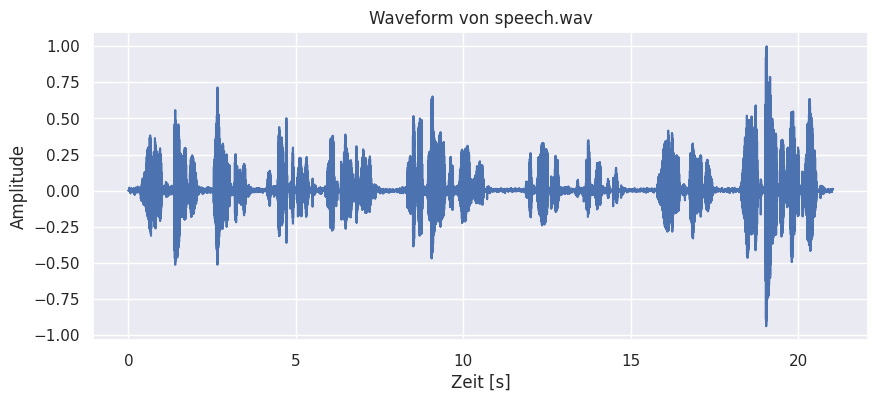

In [7]:
# listen to the sound file (if you want)
from IPython import display as ipd
ipd.Audio(s, rate=fs)

# plot the time domain signal
t = np.arange(len(s)) / fs

# Plotten des Signals
plt.figure(figsize=(10,4))
plt.plot(t, s)
plt.title("Waveform von speech.wav")
plt.xlabel("Zeit [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# put your code here to play the wave file
ipd.Audio("speech.wav")

## Block Processing

To illustrate block processing we first cut a piece of $4096$ samples, starting after $10$ seconds of audio , i.e. starting at sample no. $80,000$ for a sampling rate of $f_s = 8000 \,\mathrm{Hz}$.

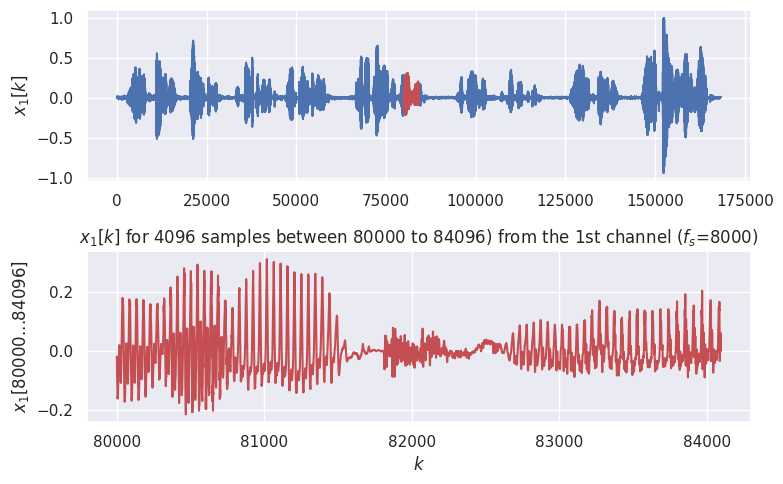

In [8]:
# lets cut out a piece of the data
start_sample  = int(10*fs);                   # start at 10 sec
no_of_samples = 4096;                         # no of samples we want to cut out
end_sample    = start_sample + no_of_samples; # last sample to be cut out
sample_vec    = np.linspace(start_sample, end_sample, no_of_samples)
x1=s[start_sample:end_sample];

plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.plot(np.arange(0,len(s)),s)
plt.ylabel('$x_1[k]$')
plt.plot(sample_vec,x1,'r')
plt.subplot(2,1,2)
plt.plot(sample_vec,x1,'r')
plt.xlabel('$k$')
plt.ylabel('$x_1$[' + str(start_sample) + '...' + str(end_sample) + ']')
plt.title('$x_1[k]$ for ' + str(len(x1)) + ' samples between '
          + str(start_sample) + ' to ' + str(end_sample) +
          ') from the 1st channel ($f_s$=' + str(fs) +')')
plt.tight_layout() # this allowes for some space for the title text.

In [9]:
# listen to the short cut-out
ipd.Audio(x1, rate=fs)

The signal $x_1[k]$, i.e. the part from the figure above, will now be further analysed on block or frame basis.
<br>
<div class="alert alert-block alert-info">
    
**Task 2:**
    
Split the signal vector in variable `x1` into smaller non-overlapping blocks of length $L_{\mathrm{Bl}}=512$ and viasualise them, similarly as in the figure below.

The python commands `range` and `enumerate` might be helpful for this.

It is not expected that you do all the annotation or colours like in the figure below. The intended learning outcome is that you are able to split a (speech) vector into smaller blocks since this will be needed for the following tasks.
</div>

![Block-Processing-Example](https://github.com/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheets/BlockProcessingExample.png?raw=1)

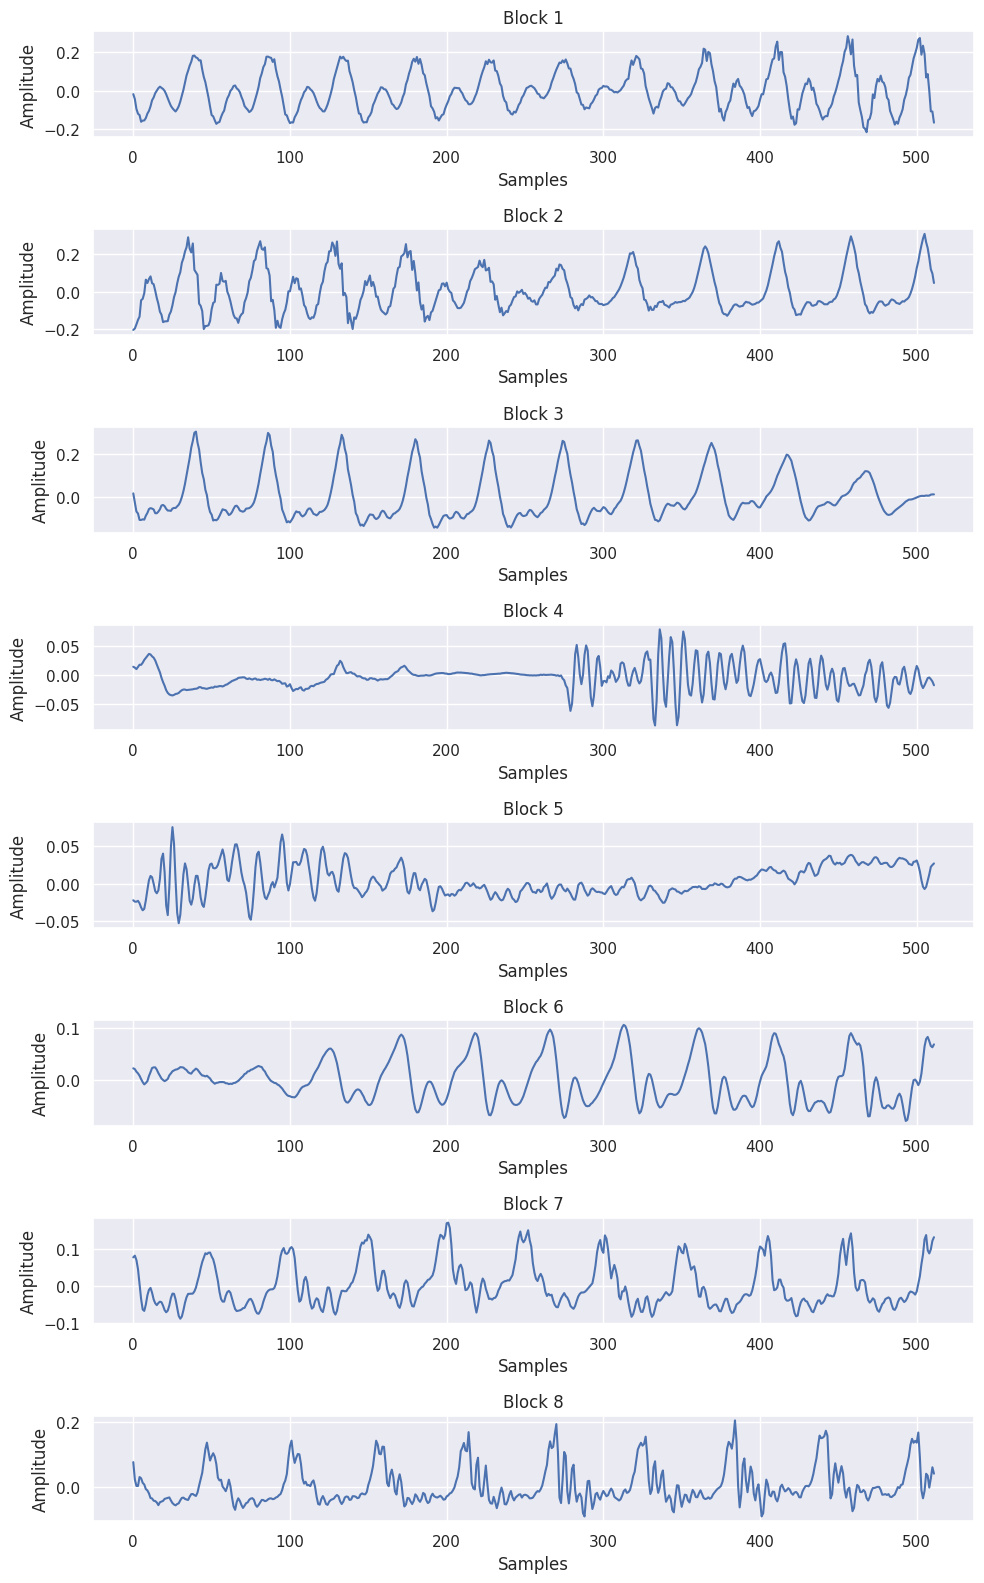

In [11]:
LBl   = 512                    # frame length (a.k.a. block length)
Lov  = 1                       # frame overlap factor (e.g. 1 for no overlap, 2 for 50% overlap)
Lhop = int(np.round(LBl/Lov)); # frame hop size

N = len(x1)                    # Gesamtlänge des Signals
num_blocks = N // LBl          # Anzahl Blöcke

plt.figure(figsize=(10, 2*num_blocks))

for idx, start_idx in enumerate(range(0, N - LBl + 1, Lhop)):
    block = x1[start_idx:start_idx+LBl]
    plt.subplot(num_blocks, 1, idx+1)
    plt.plot(block)
    plt.title(f'Block {idx+1}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


# complete the code to create smaller blocks of data.

<div class="alert alert-block alert-info">
    
**Task 2 b:**
    
Is the given block length $L_{\mathrm{Bl}}=512$ an appropriate choice for this speech signal? Please justify why or why not. (This obviously is not a programming task.)
</div>

<span style="font-weight:bold;color:orange">**YOU CAN PUT YOUR ANSWER HERE...**</span>

## Voiced / Unvoiced Detection

Download two wave files `https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/voiced_unvoiced_e.wav` and `https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/voiced_unvoiced_z.wav` and store them in variables `e` and `z`.

Please note: Since the signals you downloaded might have different sampling frequencies $f_s$, you might want to store these in different variable, like e.g. `fs_z` and `fs_e`.

In the following we will calculate

* block-based short-term energy and
* zero-crossing rate
* auto-correlation

which you can apply to all three availale signals now (`e`, `z` and `s`).

### Short-term energy

The short-term energy for each frame can be calculated by

\begin{equation}
E=\sum_{k=0}^{L_{\mathrm{Bl}}-1}s^2[k].
\label{eq:shortTermCorrelation} \tag{1}
\end{equation}
<br>
<div class="alert alert-block alert-info">
    
**Task 3: Short-Term Energy**
    
Calculate the short term energy according to \eqref{eq:shortTermCorrelation} for each block in the signal(s) and visualise them together with the signal.
</div>

In [ ]:
# your code here ()

# ...
nFrames       = int(len(signal) / sampsPerFrame)  # number of non-overlapping blocks

E = np.zeros(nFrames)
for frame in range(nFrames):
    None # replace this None by your code

### Zero-Crossing Rate

The zero crossing rate for a frame can be calculated by

\begin{equation}
\mathrm{ZCR}=\sum_{k=1}^{L_{\mathrm{BL}}−1} 0.5 |\mathrm{sign}(s[k])−\mathrm{sign}(s[k−1])|
\label{eq:zeroCrossingRate} \tag{2}
\end{equation}

Hint: The function `np.sign()` will help to implement the equation above.
<br>
<div class="alert alert-block alert-info">
    
**Task 4: Zero-Crossing Rate**
    
Calculate the zero-crossing rate for each block in the signal(s) according to \eqref{eq:zeroCrossingRate} and visualise them together with the signal.
</div>

In [ ]:
# your code here

### Correlation of two sequences

Correlation describes a statistical relationship between data, in our case between speech signals which are viewed as (realisations of) processes. This means that correlation is a measurement of similarity:
Two signals which are highly correlated (i.e., which have a strong statistical relationship) are similar to each other.

The correlation between two signals $x[k]$ and $y[k]$ is defined as <sup>[[MW1]](https://mathworld.wolfram.com/StatisticalCorrelation.html)</sup>

\begin{equation}
r_{xy} = \frac{c_{xy}}{\sigma_x \sigma_y}
\end{equation}

where $\sigma_x$ and $\sigma_y$ are the [standard deviations](https://en.wikipedia.org/wiki/Standard_deviation "Definition of standard deviation on Wikipedia") of the signals and $c_{xy}$ is the [covariance](https://en.wikipedia.org/wiki/Covariance "Definition of covariance on Wikipedia") between the two signals which can be estimated from the signals (please note that the hat ($\hat{c}$) indicates that the quantity $c$ is estimated) by <sup>[[MW2]](https://mathworld.wolfram.com/Covariance.html)</sup>

\begin{equation}
\hat{c}_{xy} = \frac{1}{L}\sum_{k=1}^L (x[k]-\bar{x})(y[k]-\bar{y})
\end{equation}

with the respective [(sample) mean](https://en.wikipedia.org/wiki/Sample_mean_and_covariance) values

$$\bar{x} = \frac{1}{L}\sum_{i=1}^L x[i],$$
$$\bar{y} = \frac{1}{L}\sum_{i=1}^L y[i].$$

With estimates for the variances $\hat{\sigma}^2_x$ and $\hat{\sigma}^2_y$,

$$\hat{\sigma}_x^2 = \frac{1}{L}\sum_{i=1}^L (x[i]-\bar{x})$$
$$\hat{\sigma}_y^2 = \frac{1}{L}\sum_{i=1}^L (y[i]-\bar{y})$$

we obtain

\begin{equation}
\hat{r}_{xy} = \frac{\sum_{k=1}^L (x[k]-\bar{x})(y[k]-\bar{y})}{L \cdot \hat{\sigma}_x \hat{\sigma}_y}.
\label{eq:defCorrelationEstWithMeanAndVariance}\tag{3}
\end{equation}

as an estimate of the correlation. If the means and standard deviations of the signals are $\bar{x}=\bar{y}=0$ and $\hat{\sigma}_x=\hat{\sigma}_y=1$, respectively, this simplifies to
\begin{equation}
\hat{r}_{xy} = \frac{1}{L}\sum_{k=1}^{L}x[k]y[k].
\label{eq:defCorrelationEst}\tag{4}
\end{equation}
<br>
<div class="alert alert-block alert-info">
    
**Task 5: Normalisation for correlation analysis (already solved)**
    
Implement a second function `normalize_and_correlate` according to equation \eqref{eq:defCorrelationEstWithMeanAndVariance} which ensures that the signals have mean of $0$ and standard deviation of $1$ by subtracting the former and dividing by the latter. Then the function `correlation` (which you are supposed to write / complete in Task 6) and return its value.
    
In the interest of time for this lab this task is already solved below. It should give us an example how to solve Task 6.
</div>
<br>
<div class="alert alert-block alert-info">
    
**Task 6: Correlation of two signals**
    
Implement a function `correlation` according to equation \eqref{eq:defCorrelationEst} which takes two signals and should return the correlation value, assuming both signals have mean $0$ and standard deviation $1$.
</div>

In [ ]:
def correlation(signal1, signal2):
    """Return the correlation value of two signals which are assumed to be normalized (mean 0, std 1)."""
    # rxy_est =  ... # complete here
    return rxy_est

def normalize_and_correlate(signal1, signal2):
    """Return the correlation value of two signals after normalizing them."""
    return correlation(
        ((signal1 - np.mean(signal1)) / np.std(signal1)),
        ((signal2 - np.mean(signal2)) / np.std(signal2)),
    )

The following (already completed) function plots two signals, their element-wise multiplication, and the resulting correlation value. The code is given as a helping function to understand the correlation. Nothing has to be changed in the code block below.

In [ ]:
def plot_correlation(signal1, signal2, title=""):
    # Ensure that both signals have the same number of samples
    assert len(signal1) == len(signal2)

    # Ensure that the signals have both mean 0 and standard deviation 1
    signal1 = (signal1 - np.mean(signal1)) / np.std(signal1)
    signal2 = (signal2 - np.mean(signal2)) / np.std(signal2)

    multiplied_signals = signal1 * signal2
    correlation_value = correlation(signal1, signal2)

    y_max = max(np.max(np.abs(signal1)), np.max(np.abs(signal2)), np.max(np.abs(multiplied_signals)))

    #fig, axs = plt.subplots(3, figsize=(12, 6))
    fig = plt.figure(figsize=(12, 6), constrained_layout=True)
    fig.suptitle(title)

    # Create grid for the different plots
    gs = fig.add_gridspec(3, 10)

    axs = [fig.add_subplot(gs[0, :-1]), fig.add_subplot(gs[1, :-1]),
           fig.add_subplot(gs[2, :-1]), fig.add_subplot(gs[:,-1])]

    axs[0].plot(np.arange(len(signal1)), signal1, marker="o", lw=0.1)
    axs[1].plot(np.arange(len(signal2)), signal2, marker="o", lw=0.1)
    axs[2].plot(np.arange(len(multiplied_signals)), multiplied_signals, marker="o", lw=0.1)
    axs[3].axhline(0, color="black", lw=0.5)
    axs[3].axhline(correlation_value, lw=3)

    axs[0].set_ylim(-y_max*1.1, y_max*1.1)
    axs[1].set_ylim(-y_max*1.1, y_max*1.1)
    axs[2].set_ylim(-y_max*1.1, y_max*1.1)
    axs[2].set_ylim(-np.max(np.abs(multiplied_signals)) * 1.1, np.max(np.abs(multiplied_signals)) * 1.1)
    axs[3].set_ylim(-1.01, 1.01)
    axs[3].set_xticks([])
    axs[0].get_xaxis().set_ticks([])
    axs[0].set_ylabel("$x[t]$")
    axs[1].set_ylabel("$y[t]$")
    axs[2].set_ylabel("$x[t]\cdot y[t]$")
    axs[1].get_xaxis().set_ticks([])
    axs[2].set_xlabel("time in samples")
    axs[0].title.set_text("The first signal $x[t]$")
    axs[1].title.set_text("The second signal $y[t]$")
    axs[2].title.set_text("Element-wise multiplication of both signals")
    axs[3].title.set_text("Correlation: {:.2f}".format(correlation_value))

#### Examples - Correlation of two sequences

We can check the correlation of different signals:
1. Correlation of a (sine) signal with itself.
2. Correlation of a sine wave with a sine wave shifted by $\pi$.
3. Correlation of two white noise signals.


<div class="alert alert-block alert-info">
    
**Task 7: Correlation of sine signals**
    
Explore the three correlations for the signals mentioned above.
</div>

##### Correlation of a (sine) signal with itself

In [ ]:
# signal1 = ... # complete the code
plot_correlation(signal1, signal1, "A signal is highly correlated with itself")

##### Correlation of a sine wave with a sine wave shifted by $\pi$.

In [ ]:
# your code here

##### Correlation of two (white) noise signals.

The code for generating the first noise signal is alradey provided below. Generate a second noise signal accordingly and explore the correlation.

In [ ]:
np.random.seed(100)
noise1 = np.random.uniform(-1, 1, size=40)

# your code here

## Copyright

This notebook is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) to be used during the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield"). You may download, [clone](https://docs.github.com/en/repositories/creating-and-managing-repositories/cloning-a-repository) or [fork](https://docs.github.com/en/get-started/quickstart/fork-a-repo) it to your computer or private [GitHub](https://github.com/) account.